## Blood Donation - Prediction

The Blood Transfusion Service Center conducts outreach to various universities, organizing blood drives to collect donations. The dataset comprises of the following columns:
<ul>
<li>Recency - months since the last donation</li>
<li>Frequency - total number of donation</li>
<li>Monetary - total blood donated in c.c.</li>
<li>Time - months since the first donation</li>
<li>a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)</li>
</ul> 

The **objective** of this project is to develop a predictive model that can forecast whether a donor will give blood during the next time the vehicle comes to campus. By accurately predicting donation behavior, the objective is to optimize blood supply management, anticipate demand fluctuations, and ultimately save more lives.

In [161]:
import warnings
#ignore deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

donation_records = pd.read_csv('blood_donations.data')
donation_records.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [163]:
donation_records.columns = ['recency', 'frequency', 'monetary', 'time', 'target']
donation_records.head(2)

,recency,frequency,monetary,time,target
0,2,50,12500,98,1
1,0,13,3250,28,1


In [164]:
donation_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   recency    748 non-null    int64
 1   frequency  748 non-null    int64
 2   monetary   748 non-null    int64
 3   time       748 non-null    int64
 4   target     748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


**Checking target incidence:**
Target incidence measures how often each target value appears in a dataset, showing the balance between 0s and 1s in the target column. This model functions as a binary classifier, i.e, there are just two possible outcomes:
<ul>
<li><code>0</code> - the donor will not give blood</li>
<li><code>1</code> - the donor will give blood</li>
</ul>

In [165]:
#rounding to 3 decimal places
donation_counts = donation_records.target.value_counts(normalize=True).round(3)

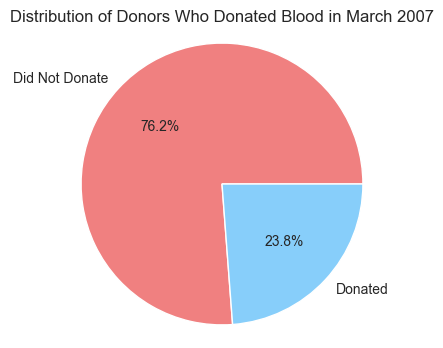

In [166]:
plt.figure(figsize=(4, 4))
plt.pie(donation_counts, labels=['Did Not Donate', 'Donated'], autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
plt.title('Distribution of Donors Who Donated Blood in March 2007')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


## Exploratory Data Analysis

Deriving insights, patterns, and answers to questions.

*What are the most influential features in predicting donor participation?*

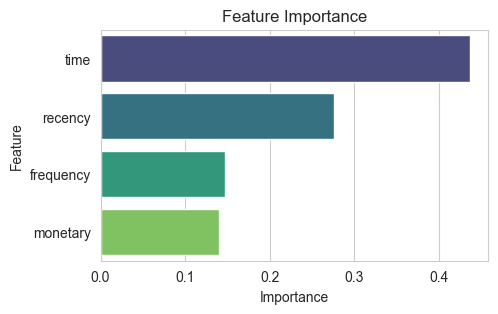

In [167]:
from sklearn.ensemble import RandomForestClassifier

#fit a Random Forest model to get feature importances
X = donation_records.drop(columns='target')
y = donation_records['target']
rf_model = RandomForestClassifier()
rf_model.fit(X, y)
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)

#feature importances in descending order
feature_importance_sorted = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(5, 3))
sns.barplot(x=feature_importance_sorted.values, y=feature_importance_sorted.index, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


**Time (months since the first donation):** This feature indicates the duration since the donor's first donation. People who have been donating blood for a longer period are more likely to continue donating in March 2007.

**Frequency (total number of donations):** Donors who have made more donations in the past may be more committed to donating regularly.

**Recency (months since the last donation):** Donors who have donated more recently may be more likely to donate again soon.

**Monetary (total blood donated in c.c.):** Donors who have donated a larger volume of blood may be more committed to the cause and more likely to donate again.

*What is the distribution of blood donation frequency among donors?*

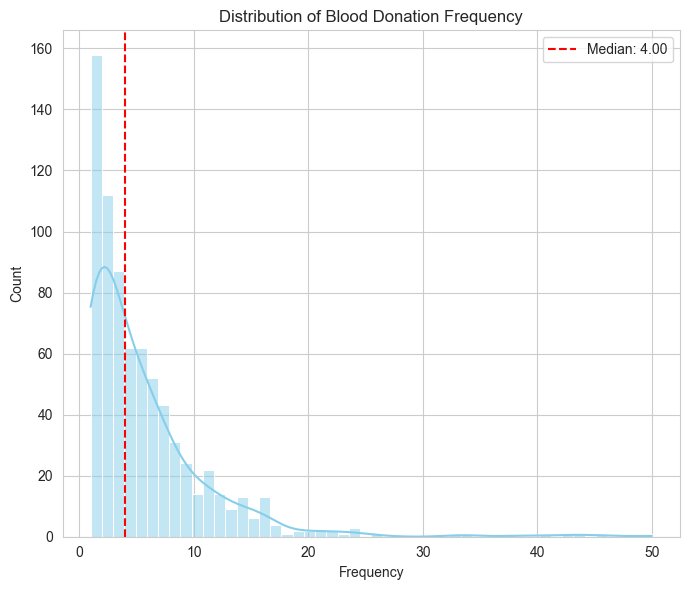

In [168]:
#median blood donation frequency
median_frequency = np.median(donation_records['frequency'])

#histogram to visualize the distribution of blood donation frequency
plt.figure(figsize=(7, 6))
sns.histplot(data=donation_records, x='frequency', bins=50, kde=True, color='skyblue')
plt.axvline(x=median_frequency, color='red', linestyle='--', label=f'Median: {median_frequency:.2f}')
plt.title('Distribution of Blood Donation Frequency')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

The histogram shows the distribution of blood donation frequencies across different levels. The frequency decreases as the number of donations increases, indicating that donors are less likely to donate blood frequently.

Since data is skewed towards lower values so median, instead of mean, has been chosen to display the measure of central tendency.
Median value of 4 for blood donation frequency indicates that half of the donors in the donated blood 4 times or less, while the other half donated blood more than 4 times.

*Is there a relationship between recency of donation and donation frequency?*

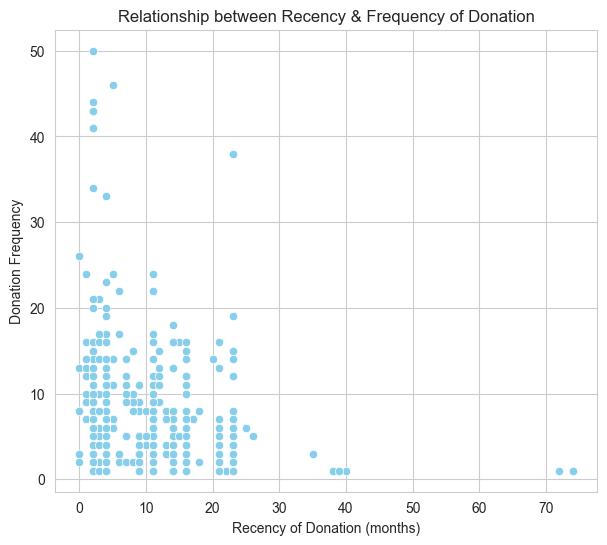

In [169]:
plt.figure(figsize=(7, 6))
sns.scatterplot(data=donation_records, x='recency', y='frequency', color='skyblue')
plt.title('Relationship between Recency & Frequency of Donation')
plt.xlabel('Recency of Donation (months)')
plt.ylabel('Donation Frequency')
plt.grid(True)
plt.show()


The clustering of points towards the left side indicates that a majority of donors have made relatively recent donations, as the time since the last donation is shorter. 
This suggests that donors are more likely to donate blood again within a relatively short time frame.

*How does the amount of blood donated vary with time since the first donation?*

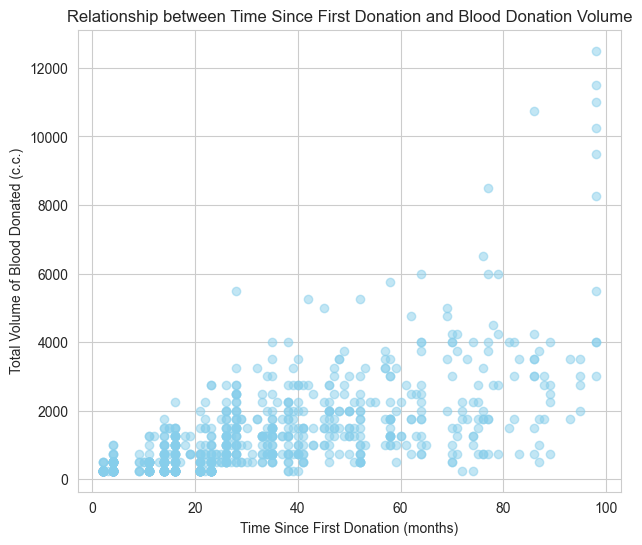

In [170]:
plt.figure(figsize=(7, 6))
plt.scatter(donation_records['time'], donation_records['monetary'], color='skyblue', alpha=0.5)
plt.title('Relationship between Time Since First Donation and Blood Donation Volume')
plt.xlabel('Time Since First Donation (months)')
plt.ylabel('Total Volume of Blood Donated (c.c.)')
plt.grid(True)
plt.show()


It can be observed that donors who have been engaged in blood donation for a longer duration tend to contribute a larger volume of blood. This may reflect a sense of commitment and loyalty to the cause of blood donation, as donors continue to support the initiative over time.

## Splitting the Dataset 
To ensure consistency, both the train and test datasets should have a 0 target incidence of 76%.

In [171]:
#splitting dataset into train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    donation_records.drop(columns='target'),
    donation_records.target,
    test_size=0.25,
    random_state=42,
    stratify=donation_records.target #to ensure proportion consistency on testing and training sets
)

X_train.head(2)

,recency,frequency,monetary,time
334,16,2,500,16
99,5,7,1750,26


## Model Selection (using TPOT)
TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming. It automatically scans through numerous pipelines to discover the most optimal one for the dataset, which can then be further improved.

In [172]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light'
)
tpot.fit(X_train, y_train)

                                                                             
Generation 1 - Current best internal CV score: 0.7422459184429089
                                                                             
Generation 2 - Current best internal CV score: 0.7422459184429089
                                                                             
Generation 3 - Current best internal CV score: 0.7422459184429089
                                                                              
Generation 4 - Current best internal CV score: 0.7422459184429089
                                                                              
Generation 5 - Current best internal CV score: 0.7422459184429089
                                                                              
Best pipeline: LogisticRegression(input_matrix, C=25.0, dual=False, penalty=l2)


TPOTClassifier(config_dict='TPOT light', disable_update_check=True,
               generations=5, population_size=20, random_state=42,
               scoring='roc_auc', verbosity=2)

TPOT picked <code>LogisticRegression</code> as the best model for our dataset with no pre-processing steps, giving the AUC score of 0.7850. 

In [173]:
#AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')

#print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    print(f'{idx}. {transform}')


AUC score: 0.7858

Best pipeline steps:
1. LogisticRegression(C=25.0, random_state=42)


In [174]:
#checking the variance, rounding it to 3 decimal places
X_train.var().round(3)

recency           66.929
frequency         33.830
monetary     2114363.700
time             611.147
dtype: float64

# Log Normalization

In [175]:
#copying X_train and X_test into X_train_normed and X_test_normed
X_train_normed, X_test_normed = X_train.copy(), X_test.copy()
col_to_normalize = 'monetary'

#log normalization
for df_ in [X_train_normed, X_test_normed]:
    df_['monetary_log'] = np.log(df_[col_to_normalize]) #add log normalized column
    df_.drop(columns=col_to_normalize, inplace=True) #drop the original column

#check the variance for X_train_normed
X_train_normed.var().round(3)

recency          66.929
frequency        33.830
time            611.147
monetary_log      0.837
dtype: float64

# Training the Model - Logistic Regression 

In [176]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(
    solver='liblinear',
    random_state=42
)

logreg.fit(X_train_normed, y_train)

#AUC score for tpot model
logreg_auc_score = roc_auc_score(y_test, logreg.predict_proba(X_test_normed)[:, 1])
print(f'\nAUC score: {logreg_auc_score:.4f}')


AUC score: 0.7891


## Conclusion

In this notebook, the significance of features such as time, frequency, recency, and monetary value was highlighted in predicting blood donation. Exploratory Data Analysis (EDA) uncovered insights into distribution of blood donation, relationships between donation recency and frequency, and between first time donation and volume of blood donated.

TPOT was utilized for automatic model selection, achieving an AUC score of 0.785. Furthermore, log normalization of the training data resulted in a 0.5% improvement in AUC score.

This analysis provides insights for blood donation centers to optimize donor outreach and retention strategies. 

In [177]:
from operator import itemgetter

#sort models based on their AUC score from highest to lowest
sorted(
    [('tpot', tpot_auc_score), ('logreg', logreg_auc_score)],
    key=itemgetter(1),
    reverse=True
)


[('logreg', 0.7890972663699937), ('tpot', 0.7857596948506039)]